<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">

# Accelerating Data Science and Leveraging Foundation Models in Digital Biology  

Copyright (c) 2025, NVIDIA CORPORATION. Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License athttp://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Part 2: Label Transfer ##

**Table of Contents**
<br>
This notebook translates the pre-processed single‑cell data into a format that supports label transfer across datasets, making use of a foundation model ([Geneformer](https://docs.nvidia.com/bionemo-framework/latest/user-guide/developer-guide/bionemo-geneformer/bionemo-geneformer-Overview/)) and a machine learning classifier.This notebook covers the below sections: 

1. [Label Transfer](#Label-Transfer)
    * [Splitting the reference and inference labels](#Splitting-the-reference-and-inference-labels)
    * [Converting from h5ad to SCDL format](#Converting-from-h5ad-to-SCDL-format)
    * [Cell Type Classificaton with Geneformer](#Cell-Type-Classificaton-with-Geneformer)
    * [Train Label Transfer](#Train-Label-Transfer)
    * [Test Label Transfer](#Test-Label-Transfer)
2. [Conclusion](#Conclusion)

For more details, please visit NVIDIA BioNeMo Framework at https://docs.nvidia.com/bionemo-framework/latest/

## Label Transfer

In this section of the lab, we will perform a label transfer task. This is useful for allowing multiple datasets to map to a unified set of labels. With this, many datasets can be combined for even more powerful analyses. 

We will use a Random Forest Classifier for the task, which will map between Geneformer embedding vectors, and the cell type labels in the dataset we have been using. 

### Splitting the reference and inference labels

Reference labels will be the set of labels that we train the classifier on, and inference labels will be the set of labels we test the classifier on. 

First we load the data from part one using `anndata`. 

In [1]:
import anndata as ad

In [4]:
adata = ad.read_h5ad("filtered_dataset.h5ad")

Check that the data shape is correct. 

.h5ad là file lưu object kiểu AnnData, một kiểu dữ liệu chính của Scanpy. Nó gồm các thành phần:

X	Ma trận biểu hiện gene (sparse hoặc dense)

obs	Metadata của từng cell (ví dụ: cell type, sample ID, condition)

var	Metadata của từng gene (ví dụ: gene symbol, gene ID)

In [5]:
adata.shape

(212613, 28152)

To train the classifier, create `refData` containing all the cells from the `10x 5' v2` and `10x 3' v3` assays. 

10x: company'name
5' / 3' from the 5' end or 3' end of the mRNA
v2 / v3: verse 2 older or verse 3

In [8]:
refData = adata[adata.obs["assay"].isin(["10x 5' v2","10x 3' v3"])].copy()

The data shape shows that `refdata` has 172,170 cells, or about 80% of the total dataset. 

CREATE TRAIN SET

In [9]:
refData.obs.shape

(172170, 39)

To test the classifier, create `inferData` containing all the cells from the `10x 5' v1` assay. 

CREATE TEST SET

In [10]:
inferData = adata[adata.obs["assay"].isin(["10x 5' v1"])].copy()

The data shape shows that `inferdata` has 40,443 cells or about 20% of the total dataset.

In [11]:
inferData.obs.shape

(40443, 39)

### Converting from h5ad to SCDL format - handle large dataset

Up until this point in the lab, we have been using the AnnData format to store the dataset. However, when running inference using BioNeMo, we can optimize the performance by using the [BioNeMo-scdl (Single Cell Data Loader)](https://docs.nvidia.com/bionemo-framework/2.0/user-guide/developer-guide/bionemo-scdl/bionemo-scdl-Overview/) format. 

This offers a few advantages over AnnData, mainly the ability to handle data sets that are too large to fit in memory. 

Setting up directories and functions to run this notebook in a reproducible manner. 

In [12]:
import os
import random
from contextlib import contextmanager

@contextmanager
def random_seed(seed:int):
    state = random.getstate()
    random.seed(seed)
    try:
        yield
    finally:
        # Go back to previous state
        random.setstate(state)

In [13]:
import shutil
from bionemo.core import BIONEMO_CACHE_DIR

create working dir


In [14]:
notebook_workdir = BIONEMO_CACHE_DIR / "notebook_tutorials" / "geneformer_celltype_classification"

if notebook_workdir.exists():
    shutil.rmtree(notebook_workdir)
notebook_workdir.mkdir(parents=True, exist_ok=True)

Start with the ref data

In [15]:
input_dir_ref = notebook_workdir / "celltype-bench-dataset-ref"
input_dir_ref.mkdir(parents=True, exist_ok=True)

In [16]:
data_dir_ref = notebook_workdir / "celltype-bench-dataset-ref-data"
result_path_ref = notebook_workdir / "results_ref.pt"

In [17]:
with random_seed(32):
    indices = list(range(len(refData)))
    random.shuffle(indices)

The `random_seed` context manager is a utility to ensure that any random operations within its scope are reproducible. 

This is particularly useful here in the context of single-cell data analysis where we perform data splitting, shuffling, and model initialization.


Now, setting up some of the parameters for managing the computational load when generating embeddings with Geneformer.

In [18]:
micro_batch_size:int = 32
num_steps:int = 2048
selection = sorted(indices[:micro_batch_size*num_steps])

Write the reference data to the input directory 

In [19]:
h5ad_outfile_ref = input_dir_ref / "hs-celltype-bench.h5ad"
refData.write_h5ad(h5ad_outfile_ref)

Run the conversion

In [20]:
!convert_h5ad_to_scdl --data-path {input_dir_ref} --save-path {data_dir_ref}

Below are the new files needed for the optimized data loader 

In [21]:
os.listdir(data_dir_ref)

['features',
 'data.npy',
 'row_ptr.npy',
 'version.json',
 'metadata.json',
 'col_ptr.npy']

Now we do the same thing for the infer data

In [22]:
# Make input directory 
input_dir_infer = notebook_workdir / "celltype-bench-dataset-infer"
input_dir_infer.mkdir(parents=True, exist_ok=True)

# Set paths for data and results 
data_dir_infer = notebook_workdir / "celltype-bench-dataset-infer-data"
result_path_infer = notebook_workdir / "results_infer.pt"

# Shuffle all indices with random seed 
with random_seed(32):
    indices = list(range(len(inferData)))
    random.shuffle(indices)

micro_batch_size:int = 32
num_steps:int = 256
selection = sorted(indices[:micro_batch_size*num_steps])

# Write the infer data to the input directory 
h5ad_outfile_infer = input_dir_infer / "hs-celltype-bench.h5ad"
inferData.write_h5ad(h5ad_outfile_infer)

# Run the conversion to scdl
!convert_h5ad_to_scdl --data-path {input_dir_infer} --save-path {data_dir_infer}

Check that the output files were written 

In [23]:
os.listdir(data_dir_infer)

['features',
 'data.npy',
 'row_ptr.npy',
 'version.json',
 'metadata.json',
 'col_ptr.npy']

### Cell Type Classificaton with Geneformer 

The data is now in an optimized format to be ingested by Geneformer and we can run inference. In this lab we will be using [Geneformer through BioNeMo Frameworks](https://docs.nvidia.com/bionemo-framework/2.3/models/geneformer/) to run model inference. 

BioNeMo is a software ecosystem produced by NVIDIA for the development and deployment of life sciences-oriented artificial intelligence models. BioNeMo provides a set of tools to help researchers build, train, and deploy AI models for various biological applications.

- BioNeMo Framework: a free-to-use collection of programming tools and packages offering access to optimized, pre-trained biomolecular models and workflows. The framework enables building and customizing models, including training and fine-tuning. Capabilities span various workloads and therapeutic modalities, such as molecular generation, protein structure prediction, protein-ligand, and representation learning.

[Geneformer](https://www.nature.com/articles/s41586-023-06139-9) is a foundational single-cell RNA (scRNA) language model using a BERT architecture trained on millions of single-cell RNA sequences. It captures gene co-expression patterns to learn cellular representations, enabling predictive tasks across biology and medicine. Geneformer is trained on a masked language model (MLM) objective, where expression rank-ordered "gene tokens" in single-cell RNA sequences are masked, replaced, or left unchanged, and the model learns to predict these masked genes based on context.

Use the BioNeMo [helper script](https://docs.nvidia.com/bionemo-framework/latest/user-guide/getting-started/development/) to download the Geneformer 106M parameter model checkpoint. 

Dung genformer model de encode bieu hien gene thanh vector 768 chieu

Bieu hien gene la luowng mRNA cua tung gene do duoc trong te bao

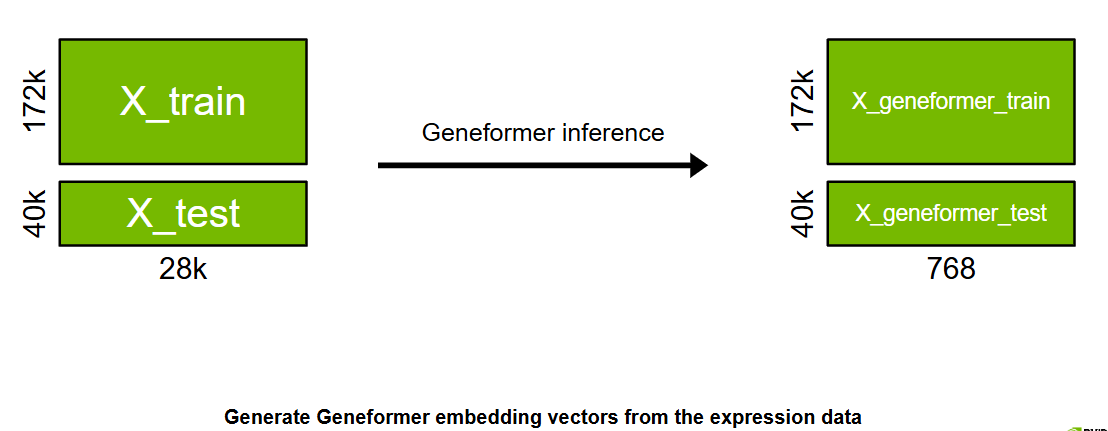

In [24]:
geneformer_106m_out = !download_bionemo_data "geneformer/106M_240530:2.0"

The result includes a list of outputs, the last one is the path 

In [25]:
geneformer_106m = geneformer_106m_out[-1]

In [26]:
result_path_106m = notebook_workdir / "results_106m.pt"

Set some hyperparameters based on your system. Check the GPU resources available using `nvidia-smi`

In [27]:
num_gpus = 1
micro_batch_size:int = 256

Run inference on the training data

In [ ]:
!infer_geneformer \
    --data-dir {data_dir_ref} \
    --checkpoint-path {geneformer_106m} \
    --results-path {result_path_ref} \
    --micro-batch-size {micro_batch_size} \
    --seq-len 2048 \
    --num-dataset-workers 10 \
    --num-gpus {num_gpus} \
    --include-input-ids

[WARNING  | bitsandbytes.cextension]: Could not find the bitsandbytes CUDA binary at PosixPath('/usr/local/lib/python3.12/dist-packages/bitsandbytes/libbitsandbytes_cuda128.so')
[WARNING  | bitsandbytes.cextension]: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
[NeMo W 2025-07-25 18:08:25 nemo_logging:405] /usr/local/lib/python3.12/dist-packages/pyannote/core/notebook.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
      cm = get_cmap("Set1")
    
[NeMo W 2025-07-25 18:08:30 nemo_logging:405] Tokenizer vocab file: /root/.cache/bionemo/d8e3ea569bc43768c24aa651aff77722df202078415528497c22394046b08cc3-singlecell-scdltestdata-20241203.tar.gz.untar/cellxgene_2023-12-15_small_processed_scdl/train/geneformer.voc

Inference on ref data took around 17 minutes on 1 A100 GPU

We can see the output files containing the predictions

In [34]:
os.listdir(result_path_ref)

[]

Run inference on the test data

In [ ]:
!infer_geneformer \
    --data-dir {data_dir_infer} \
    --checkpoint-path {geneformer_106m} \
    --results-path {result_path_infer} \
    --micro-batch-size {micro_batch_size} \
    --seq-len 2048 \
    --num-dataset-workers 10 \
    --num-gpus {num_gpus} \
    --include-input-ids

Inference on infer data took around 4 minutes on 1 A100 GPU. 

We can see the output files containing the predictions. 

In [ ]:
os.listdir(result_path_infer)

Lastly, we want to add these classifications to our main AnnData object as an `obsm`. Below is a helper script for that operation. 

In [ ]:
import torch
import numpy as np

In [ ]:
def concat_results_to_adata(adata, result_path, num_gpus, batchsize):
    data_sets = []
    for i in range(num_gpus):
        inter_emb = torch.load(result_path / f"predictions__rank_{i}.pt", weights_only=False)['embeddings'].float().cpu().numpy()
        data_sets.append(inter_emb)
    global_batch_size = batchsize*num_gpus
    out = np.zeros((adata.shape[0],data_sets[0].shape[1]),dtype=np.float32)
    for i in range(num_gpus):
        emd = data_sets[i]
        n_batches = (emd.shape[0]+batchsize-1)//batchsize
        for j in range(n_batches):
            start = j*batchsize
            stop = min((j+1)*batchsize, emd.shape[0])
            start_global = i*batchsize +j*global_batch_size
            stop_global = start_global +stop-start
            out[start_global:stop_global] = emd[start:stop]
    adata.obsm["X_geneformer"] = out

Add the ref data predictions to the anndata object. 

In [ ]:
concat_results_to_adata(refData, result_path_ref, num_gpus, micro_batch_size)

Notice how the `obsm` attribute now has a `X_geneformer` array. 

In [ ]:
refData.obsm

Taking a look at the same, we can see that for each cell, there is an embedding vector of length 768 that represents the cell type prediction. 

In [ ]:
refData.obsm["X_geneformer"].shape

Do the same for `inferData`. 

In [ ]:
concat_results_to_adata(inferData, result_path_infer, num_gpus, micro_batch_size)
inferData.obsm
inferData.obsm["X_geneformer"].shape

### Train Label Transfer

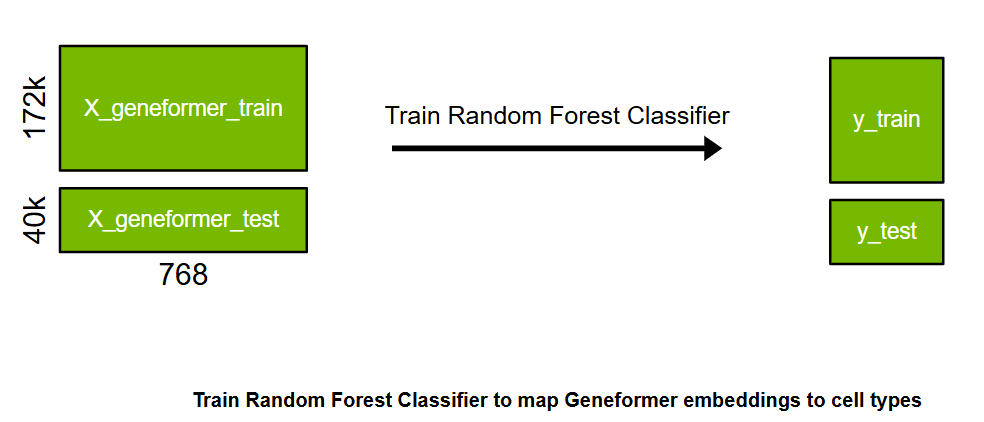

Now that we have the geneformer embeddings, we can train the Random Forest Classifier for the Label Transfer task. 

Create a training and test dataset for label transfer. 

In [ ]:
from cuml.model_selection import train_test_split

Tu cac embedding token tu Xgeneformer trên tap Reference -> classify cac loai te bao Cell Types

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(refData.obsm["X_geneformer"], refData.obs["cell_type"].cat.codes.to_numpy(), random_state=0)

For the model, we will create a [RandomForestClassifier](https://docs.rapids.ai/api/cuml/stable/api/#cuml.ensemble.RandomForestClassifier) using cuML. 

In [ ]:
from cuml.ensemble import RandomForestClassifier as cuRF

In [ ]:
model = cuRF(random_state=0, n_streams=1)

Train the model. 

In [ ]:
trained_RF = model.fit(X_train, y_train)

Predict on the held out test labels. 

In [ ]:
# memory management issue (close other notebooks?) 
predictions = model.predict(X_test)

Calculate the training accuracy. 

In [ ]:
from cupy import asnumpy
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(asnumpy(y_test), asnumpy(predictions))

### Test Label Transfer

Now that the label transfer model is trained, we can use it to run predictions on the test set to evaluate the inference performance of the model. 

Tren tap Inference

In [ ]:
test_predictions = model.predict(inferData.obsm["X_geneformer"])

Calculate accuracy, precision, recall, and F1 score. 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
accuracy_score(inferData.obs["cell_type"].cat.codes.to_numpy(), asnumpy(test_predictions))

In [ ]:
precision_score(inferData.obs["cell_type"].cat.codes.to_numpy(), asnumpy(test_predictions), average="macro")

In [ ]:
recall_score(inferData.obs["cell_type"].cat.codes.to_numpy(), asnumpy(test_predictions), average="macro")

In [ ]:
f1_score(inferData.obs["cell_type"].cat.codes.to_numpy(), asnumpy(test_predictions), average="macro")

## Conclusion

The notebook successfully demonstrates a state‑of‑the‑art workflow where single‑cell gene expression data are converted into informative embeddings using a foundation model -- Geneformer, unifying single-cell datasets by transferring labels across technologies (e.g., different sequencing assays). 

This integrated approach enables scalable, cross-dataset analysis for large-scale biological discovery.

Now **shut down the kernel** so this notebook stops using memory. 

In [ ]:
# DO NOT CHANGE THIS CELL
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(False)

**Note**: Executing the provided code cell will shut down the kernel and activate a popup indicating that the kernel has restarted.

<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">